# Inverted Pendulum on a Drone

This notebook is used to design a controller for the inverted pendulum on a Crazyflie system. The notebook goes over the derivation of the dynamics of a simplified system and plugs in these equations into the full dynamics of the drone. Using a linearized state-space version of the full system (now with 14 states that represent the drone and the pendulum), the controller for the drone is designed to balance the pendulum in its upright position.

In [65]:
import numpy as np
import sympy as sym
import matplotlib.pyplot as plt
from numpy import linalg
import scipy

import json
from scipy import linalg
from sympy.physics.mechanics import *

### Variable Setup

The new information added here are the states of the pendulum, $\alpha$ and $\dot{\alpha}$ which represent the angular position and angular velocity of the pendulum.

Define states

In [66]:
# components of position (meters)
o_x, o_y, o_z = sym.symbols('o_x, o_y, o_z')

# yaw, pitch, and roll angles (radians)
psi, theta, phi = sym.symbols('psi, theta, phi')

# components of linear velocity (meters / second)
v_x, v_y, v_z = sym.symbols('v_x, v_y, v_z')

# components of angular velocity (radians / second)
w_x, w_y, w_z = sym.symbols('w_x, w_y, w_z')

# states of the pendulum
alpha, alpha_dot = sym.symbols('alpha, alpha_dot')

Define inputs

In [67]:
# components of net rotor torque
tau_x, tau_y, tau_z = sym.symbols('tau_x, tau_y, tau_z')

# net rotor force
f_z = sym.symbols('f_z')

Define parameters.
$m_{pen}$ is the mass of the pendulum and $l_{pen}$ is the distance of the center of mass of the pendulum from its base.

In [68]:
m, J_x, J_y, J_z, g, m_pen, l_pen = sym.symbols('m, J_x, J_y, J_z, g, m_pen, l_pen')

Create linear and angular velocity vectors (in coordinates of the body frame).

In [69]:
v_01in1 = sym.Matrix([v_x, v_y, v_z])
w_01in1 = sym.Matrix([w_x, w_y, w_z])

Create moment of inertia matrix (in coordinates of the body frame).

In [70]:
J_in1 = sym.diag(J_x, J_y, J_z)

## Define kinematics of orientation

### Rotation matrix in terms of yaw, pitch, roll angles

Define individual rotation matrices.

In [71]:
Rz = sym.Matrix([[sym.cos(psi), -sym.sin(psi), 0],
                 [sym.sin(psi), sym.cos(psi), 0],
                 [0, 0, 1]])

Ry = sym.Matrix([[sym.cos(theta), 0, sym.sin(theta)],
                 [0, 1, 0],
                 [-sym.sin(theta), 0, sym.cos(theta)]])

Rx = sym.Matrix([[1, 0, 0],
                 [0, sym.cos(phi), -sym.sin(phi)],
                 [0, sym.sin(phi), sym.cos(phi)]])

Apply sequential transformation to compute the rotation matrix that describes the orientation of the drone (i.e., of frame 1 in the coordinates of frame 0).

In [72]:
R_1in0 = Rz * Ry * Rx

In [73]:
R_1in0

Matrix([
[cos(psi)*cos(theta), sin(phi)*sin(theta)*cos(psi) - sin(psi)*cos(phi),  sin(phi)*sin(psi) + sin(theta)*cos(phi)*cos(psi)],
[sin(psi)*cos(theta), sin(phi)*sin(psi)*sin(theta) + cos(phi)*cos(psi), -sin(phi)*cos(psi) + sin(psi)*sin(theta)*cos(phi)],
[        -sin(theta),                              sin(phi)*cos(theta),                               cos(phi)*cos(theta)]])

### Map from angular velocity to angular rates

Recall that

$$\begin{bmatrix} \dot{\psi} \\ \dot{\theta} \\ \dot{\phi} \end{bmatrix} = N w_{0, 1}^{1}$$

for some matrix $N$. Here is how to compute that matrix for a ZYX (yaw, pitch, roll) Euler angle sequence.  First, we compute its inverse:

In [74]:
Ninv = sym.Matrix.hstack((Ry * Rx).T * sym.Matrix([0, 0, 1]),
                              (Rx).T * sym.Matrix([0, 1, 0]),
                                       sym.Matrix([1, 0, 0]))

Then, we compute $N$ by taking the inverse of $N^{-1}$:

In [75]:
N = sym.simplify(Ninv.inv())

In [76]:
N

Matrix([
[0, sin(phi)/cos(theta), cos(phi)/cos(theta)],
[0,            cos(phi),           -sin(phi)],
[1, sin(phi)*tan(theta), cos(phi)*tan(theta)]])

### Deriving the Kinematics of the Pendulum

Generalized Co-ordinates: $x$, $z$ (in the world frame), $\theta$ (pitch) and $\alpha$ (angle of the drone from the world $z_0$)

This derivation deals with the planar problem that ignores the 3D effects of the roll, yaw and y-direction movement of the pendulum. The equations of motion from this are then added to the existing equations of motion.

![pendulum_kin](Inverted_Pendulum_Kinematics.jpg)

Dynamic copies of the symbolic variables are set up below (symbolic variables that are functions of time). The Lagrangian of this system are then calculated, and then Lagrangian equations are used to derive the equations of motion of the joint system.

In [77]:
dyn_o_x, dyn_o_z, dyn_alpha, dyn_theta = dynamicsymbols(r'o_x o_z \alpha \theta')
dyn_o_xd, dyn_o_zd, dyn_alphad, dyn_thetad = dynamicsymbols(r'o_x o_z \alpha \theta', 1)
dyn_o_xdd, dyn_o_zdd, dyn_alphadd, dyn_thetadd = dynamicsymbols(r'o_x o_z \alpha \theta', 2)
L = 1/2*m*(dyn_o_xd**2 + dyn_o_zd**2) + 1/2*J_y*(dyn_thetad**2) + 1/2*m_pen*(dyn_o_xd**2 + dyn_o_zd**2 + l_pen**2 * dyn_alphad**2 + 2*l_pen*dyn_alphad*(dyn_o_xd*sym.cos(dyn_alpha) - dyn_o_zd*sym.sin(dyn_alpha))) - m*g*dyn_o_z - m_pen*g*(dyn_o_z + l_pen*sym.cos(dyn_alpha))
dyn_f_z, dyn_tau_y = sym.symbols(r'f_z, \tau_y')
t = sym.Symbol('t')

Equations = sym.Matrix([[sym.simplify(sym.diff(sym.diff(L, dyn_o_xd), t) - sym.diff(L, dyn_o_x) - dyn_f_z*sym.sin(dyn_theta))],
             [sym.simplify(sym.diff(sym.diff(L, dyn_o_zd), t) - sym.diff(L, dyn_o_z) - dyn_f_z*sym.cos(dyn_theta))],
             [sym.simplify(sym.diff(sym.diff(L, dyn_alphad), t) - sym.diff(L, dyn_alpha))],
             [sym.simplify(sym.diff(sym.diff(L, dyn_thetad), t) - sym.diff(L, dyn_theta) - dyn_tau_y)]])

Equations

Matrix([
[                   -f_z*sin(\theta(t)) + 1.0*m*Derivative(o_x(t), (t, 2)) + m_pen*(-l_pen*sin(\alpha(t))*Derivative(\alpha(t), t)**2 + l_pen*cos(\alpha(t))*Derivative(\alpha(t), (t, 2)) + Derivative(o_x(t), (t, 2)))],
[-f_z*cos(\theta(t)) + g*m + g*m_pen + 1.0*m*Derivative(o_z(t), (t, 2)) - 1.0*m_pen*(l_pen*sin(\alpha(t))*Derivative(\alpha(t), (t, 2)) + l_pen*cos(\alpha(t))*Derivative(\alpha(t), t)**2 - Derivative(o_z(t), (t, 2)))],
[                                                          l_pen*m_pen*(-g*sin(\alpha(t)) + l_pen*Derivative(\alpha(t), (t, 2)) - sin(\alpha(t))*Derivative(o_z(t), (t, 2)) + cos(\alpha(t))*Derivative(o_x(t), (t, 2)))],
[                                                                                                                                                                         1.0*J_y*Derivative(\theta(t), (t, 2)) - \tau_y]])

The equations of motion above are solved to find the expressions for $\ddot{o}_x$, $\ddot{o}_z$, $\ddot{\alpha}$, and $\ddot{\theta}$. The dynamic symbols are then substituted for the state and input variables set before.

In [78]:
# Solving for the second derivatives
ox_ddot_with_alphaddot = sym.solve(Equations[0,0], dyn_o_xdd)[0]
oz_ddot_with_alphaddot = sym.solve(Equations[1,0], dyn_o_zdd)[0]
alpha_ddot_eqn = Equations[2].subs([(dyn_o_xdd, ox_ddot_with_alphaddot), (dyn_o_zdd, oz_ddot_with_alphaddot)])
alpha_ddot_soln = sym.simplify(sym.solve(alpha_ddot_eqn, dyn_alphadd)[0])
theta_ddot_soln = sym.solve(Equations[3,0], dyn_thetadd)[0]
new_ox_ddot = sym.simplify(ox_ddot_with_alphaddot.subs(dyn_alphadd, alpha_ddot_soln))
new_oz_ddot = sym.simplify(oz_ddot_with_alphaddot.subs(dyn_alphadd, alpha_ddot_soln))

# Substituting the standard symbolic variables
theta_ddot_soln = theta_ddot_soln.subs(dyn_tau_y, tau_y)
new_ox_ddot = new_ox_ddot.subs([(dyn_f_z, f_z), (dyn_theta, theta), (dyn_alphad, alpha_dot)])
new_ox_ddot = new_ox_ddot.subs(dyn_alpha, alpha)
new_oz_ddot = new_oz_ddot.subs([(dyn_f_z, f_z), (dyn_theta, theta), (dyn_alphad, alpha_dot)])
new_oz_ddot = new_oz_ddot.subs(dyn_alpha, alpha)
alpha_ddot_soln = alpha_ddot_soln.subs([(dyn_alpha, alpha), (dyn_theta, theta), (dyn_f_z, f_z)])

The planar problem is set up to be linearized with the 4 variables mentioned above and their time derivatives.

In [79]:
o_x_dot, o_z_dot, theta_dot = sym.symbols(r'o_x_dot, o_z_dot, theta_dot')

f_sym_planar = sym.Matrix.vstack(sym.Matrix([o_x_dot]),
                          sym.Matrix([new_ox_ddot]),
                          sym.Matrix([o_z_dot]),
                          sym.Matrix([new_oz_ddot]),
                          sym.Matrix([theta_dot]),
                          sym.Matrix([theta_ddot_soln]),
                          sym.Matrix([alpha_dot]),
                          sym.Matrix([alpha_ddot_soln])
                          )
f_sym_planar

Matrix([
[                                                                                                                             o_x_dot],
[               (-f_z*m_pen*sin(alpha - theta)*cos(alpha) + m*(alpha_dot**2*l_pen*m_pen*sin(alpha) + f_z*sin(theta)))/(m*(m + m_pen))],
[                                                                                                                             o_z_dot],
[(f_z*m_pen*sin(alpha)*sin(alpha - theta) + m*(alpha_dot**2*l_pen*m_pen*cos(alpha) + f_z*cos(theta) - g*m - g*m_pen))/(m*(m + m_pen))],
[                                                                                                                           theta_dot],
[                                                                                                                           tau_y/J_y],
[                                                                                                                           alpha_dot],
[                                      

In [80]:
s_planar = [o_x, o_x_dot, o_z, o_z_dot, theta, theta_dot, alpha, alpha_dot]
i_planar = [tau_y, f_z]
p_planar = [m, J_y, g, m_pen, l_pen]
s_with_des_planar = [o_x, o_z]

In [81]:
f_planar = sym.lambdify(s_planar + i_planar + p_planar, f_sym_planar)
f_planar

<function _lambdifygenerated(o_x, o_x_dot, o_z, o_z_dot, theta, theta_dot, alpha, alpha_dot, tau_y, f_z, m, J_y, g, m_pen, l_pen)>

The values for the constants are given but only for the planar case so the full system derivation that follows can still use the symbolic variables.

In [82]:
# Mass
m_planar = 0.044

# Principle moments of inertia
J_y_planar = 1.60e-05

# Acceleration of gravity
g_planar = 9.81

# Pendulum parameters
l_pen_planar = 150e-3 # maybe m
m_pen_planar = 0.006

Checking if the equillibrium point is valid

In [83]:
p_planar_eq = [m_planar, J_y_planar, g_planar, m_pen_planar, l_pen_planar]
s_planar_eq = [0., 0., 0., 0., 0., 0., 0., 0.]
i_planar_eq = [0., g_planar*(m_planar + m_pen_planar)]

In [84]:
print(f_planar(*s_planar_eq, *i_planar_eq, *p_planar_eq))

[[ 0.0000000e+00]
 [ 0.0000000e+00]
 [ 0.0000000e+00]
 [-6.9388939e-16]
 [ 0.0000000e+00]
 [ 0.0000000e+00]
 [ 0.0000000e+00]
 [ 0.0000000e+00]]


The system is then linearized into the state space model at this equilibrium point.

In [85]:
A_planar_sym = f_sym_planar.jacobian(s_planar)
B_planar_sym = f_sym_planar.jacobian(i_planar)

A_planar_num = sym.lambdify(s_planar + i_planar + p_planar, A_planar_sym)
B_planar_num = sym.lambdify(s_planar + i_planar + p_planar, B_planar_sym)

A_planar = A_planar_num(*s_planar_eq, *i_planar_eq, *p_planar_eq)
B_planar = B_planar_num(*s_planar_eq, *i_planar_eq, *p_planar_eq)

In [86]:
A_planar_str = np.array2string(A_planar,
                        formatter={'float_kind': lambda x: f'{x:5.2f}'},
                        prefix='    ',
                        max_line_width=np.inf)

print(f'A = {A_planar_str}')

A = [[ 0.00  1.00  0.00  0.00  0.00  0.00  0.00  0.00]
     [ 0.00  0.00  0.00  0.00 11.15  0.00 -1.34  0.00]
     [ 0.00  0.00  0.00  1.00  0.00  0.00  0.00  0.00]
     [ 0.00  0.00  0.00  0.00 -0.00  0.00  0.00  0.00]
     [ 0.00  0.00  0.00  0.00  0.00  1.00  0.00  0.00]
     [ 0.00  0.00  0.00  0.00  0.00  0.00  0.00  0.00]
     [ 0.00  0.00  0.00  0.00  0.00  0.00  0.00  1.00]
     [ 0.00  0.00  0.00  0.00 -74.32  0.00 74.32  0.00]]


In [87]:
B_planar_str = np.array2string(B_planar,
                        formatter={'float_kind': lambda x: f'{x:10.2f}'},
                        prefix='    ',
                        max_line_width=np.inf)
print(f'B = {B_planar_str}')

B = [[      0.00       0.00]
     [      0.00       0.00]
     [      0.00       0.00]
     [      0.00      20.00]
     [      0.00       0.00]
     [  62500.00       0.00]
     [      0.00       0.00]
     [      0.00       0.00]]


We can check if this planar problem is controllable or not by looking at the controllability matrix for the above state-space model.

In [88]:
W_planar = np.block([[B_planar, A_planar @ B_planar, A_planar @ A_planar @ B_planar, np.linalg.matrix_power(A_planar, 3) @ B_planar, np.linalg.matrix_power(A_planar, 4) @ B_planar, np.linalg.matrix_power(A_planar, 5) @ B_planar, np.linalg.matrix_power(A_planar, 6) @ B_planar, np.linalg.matrix_power(A_planar, 7) @ B_planar]])

np.linalg.matrix_rank(W_planar) # If 8, the system is controllable

8

This shows that the planar problem and the system above is controllable. In the next section, these equations will be used in the full system state-space model to derive a controller.

## Define equations of motion

We once again consider the equations of motion of the full-system, and not just the planar problem.

Forces.

In [89]:
f_in1 = R_1in0.T * sym.Matrix([0, 0, -m * g]) + sym.Matrix([0, 0, f_z])

Torques.

In [90]:
tau_in1 = sym.Matrix([tau_x, tau_y, tau_z])

In [91]:
f_in1

Matrix([
[               g*m*sin(theta)],
[     -g*m*sin(phi)*cos(theta)],
[f_z - g*m*cos(phi)*cos(theta)]])

In [92]:
tau_in1

Matrix([
[tau_x],
[tau_y],
[tau_z]])

The block below calculates the new system of forces in the body frame that are taken from the expressions for $\ddot{o}_x$ and $\ddot{o}_z$. There is potential for error here, and could be resulting in the lack of full controllability of the complete system.


In [93]:
new_f_in1 = R_1in0.T * sym.Matrix([(m)*new_ox_ddot, 0, (m)*new_oz_ddot])
sym.simplify(new_f_in1)

Matrix([
[                                        (-(f_z*m_pen*sin(alpha)*sin(alpha - theta) + m*(alpha_dot**2*l_pen*m_pen*cos(alpha) + f_z*cos(theta) - g*m - g*m_pen))*sin(theta) - (f_z*m_pen*sin(alpha - theta)*cos(alpha) - m*(alpha_dot**2*l_pen*m_pen*sin(alpha) + f_z*sin(theta)))*cos(psi)*cos(theta))/(m + m_pen)],
[(-(sin(phi)*sin(theta)*cos(psi) - sin(psi)*cos(phi))*(f_z*m_pen*sin(alpha - theta)*cos(alpha) - m*(alpha_dot**2*l_pen*m_pen*sin(alpha) + f_z*sin(theta))) + (f_z*m_pen*sin(alpha)*sin(alpha - theta) + m*(alpha_dot**2*l_pen*m_pen*cos(alpha) + f_z*cos(theta) - g*m - g*m_pen))*sin(phi)*cos(theta))/(m + m_pen)],
[(-(sin(phi)*sin(psi) + sin(theta)*cos(phi)*cos(psi))*(f_z*m_pen*sin(alpha - theta)*cos(alpha) - m*(alpha_dot**2*l_pen*m_pen*sin(alpha) + f_z*sin(theta))) + (f_z*m_pen*sin(alpha)*sin(alpha - theta) + m*(alpha_dot**2*l_pen*m_pen*cos(alpha) + f_z*cos(theta) - g*m - g*m_pen))*cos(phi)*cos(theta))/(m + m_pen)]])

Create equations of motion. Here, we include the dynamics of the pendulum in the new terms for $\alpha$ and $\dot{\alpha}$

In [94]:
f_sym = sym.Matrix.vstack(R_1in0 * v_01in1,
                          N * w_01in1,
                          (1 / m) * (new_f_in1 - w_01in1.cross(m * v_01in1)),
                          J_in1.inv() * (tau_in1 - w_01in1.cross(J_in1 * w_01in1)),
                          sym.Matrix([alpha_dot]),
                          sym.Matrix([alpha_ddot_soln])
                          )

Show equations of motion, which have the form

$$\dot{s} = f(s, i, p)$$

for states

$$
s = \begin{bmatrix} o_x \\ o_y \\ o_z \\ \psi \\ \theta \\ \phi \\ v_x \\ v_y \\ v_z \\ w_x \\ w_y \\ w_z \\ \alpha \\ \dot{\alpha} \end{bmatrix},
$$

inputs
$$
i = \begin{bmatrix} \tau_x \\ \tau_y \\ \tau_z \\ f_z \end{bmatrix},
$$

and parameters
$$
p = \begin{bmatrix} m \\ J_x \\ J_y \\ J_z \\ g \\ m_{pen} \\ l_{pen} \end{bmatrix}.
$$

In [95]:
f_sym

Matrix([
[                                                                                                                                                                                                               v_x*cos(psi)*cos(theta) + v_y*(sin(phi)*sin(theta)*cos(psi) - sin(psi)*cos(phi)) + v_z*(sin(phi)*sin(psi) + sin(theta)*cos(phi)*cos(psi))],
[                                                                                                                                                                                                              v_x*sin(psi)*cos(theta) + v_y*(sin(phi)*sin(psi)*sin(theta) + cos(phi)*cos(psi)) + v_z*(-sin(phi)*cos(psi) + sin(psi)*sin(theta)*cos(phi))],
[                                                                                                                                                                                                                                                                                     -v_x*sin(theta) +

# Derive state-space model

## Choose equilibrium point

An equilibrium point of the nonlinear system is a choice of states $s_\text{eq}$ and inputs $i_\text{eq}$ - along with constant parameters $p_\text{eq}$ - for which

$$0 = f(s_\text{eq}, i_\text{eq}, p_\text{eq}).$$

Create a list of states, inputs, and parameters as symbolic variables.

In [96]:
s = [o_x, o_y, o_z, psi, theta, phi, v_x, v_y, v_z, w_x, w_y, w_z, alpha, alpha_dot]
i = [tau_x, tau_y, tau_z, f_z]
p = [m, J_x, J_y, J_z, g, m_pen, l_pen]

Create a list of states to track as symbolic variables. These are states whose desired values will be specified by a client.

In [97]:
s_with_des = [o_x, o_y, o_z]

Create a function that evaluates $f(\cdot)$ at particular values of $s$, $i$, and $p$.

In [98]:
f = sym.lambdify(s + i + p, f_sym)

In [99]:
f

<function _lambdifygenerated(o_x, o_y, o_z, psi, theta, phi, v_x, v_y, v_z, w_x, w_y, w_z, alpha, alpha_dot, tau_x, tau_y, tau_z, f_z, m, J_x, J_y, J_z, g, m_pen, l_pen)>

Define constants.

In [100]:
# Mass
m = 0.044

# Principle moments of inertia
J_x = 1.57e-05
J_y = 1.60e-05
J_z = 2.05e-05

# Acceleration of gravity
g = 9.81

# Pendulum parameters
l_pen = 150e-3 # maybe m
m_pen = 0.006

Create a list of parameter values in the **same order** as the symbolic list. These are the parameter estimates we found in our experiments. They are not choices. (We use the subscript `_eq` to be consistent with what follows, and could say "parameter values *at equilibrium*," but don't be misled. These parameter values are *given* and are *constant* - again, they aren't choices.)

In [101]:
p_eq = [m, J_x, J_y, J_z, g, m_pen, l_pen]

Create a list of state and input values at equilibrium in the **same order** as the symbolic lists.

In [102]:
s_eq = [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]
i_eq = [0., 0., 0., g*(m + m_pen)] # Notice that the mass of the pendulum is now factored into the equilibrium point

Evaluate the equations of motion at the equilibrium point - if it actually *is* an equilibrium point, then the result should be an array of zeros:

In [103]:
print(f(*s_eq, *i_eq, *p_eq))

[[ 0.0000000e+00]
 [ 0.0000000e+00]
 [ 0.0000000e+00]
 [ 0.0000000e+00]
 [ 0.0000000e+00]
 [ 0.0000000e+00]
 [ 0.0000000e+00]
 [ 0.0000000e+00]
 [-6.9388939e-16]
 [ 0.0000000e+00]
 [ 0.0000000e+00]
 [ 0.0000000e+00]
 [ 0.0000000e+00]
 [ 0.0000000e+00]]


Note that this equilibrium point would remain an equilibrium point for any choice of `o_x`, `o_y`, and `o_z` - that is one thing that allows the controller to track desired values of these variables.

## 3.2 Compute A and B

We want to find

$$
A = \frac{\partial f}{\partial s}\biggr\vert_{(s, i, p) = (s_\text{eq}, i_\text{eq}, p_\text{eq})}
\qquad\text{and}\qquad
B = \frac{\partial f}{\partial i}\biggr\vert_{(s, i, p) = (s_\text{eq}, i_\text{eq}, p_\text{eq})}.
$$

First, we compute each Jacobian (i.e., each matrix of partial derivatives) in symbolic form.

In [104]:
A_sym = f_sym.jacobian(s)
B_sym = f_sym.jacobian(i)

Then, we create functions that allow us to evaluate these Jacobians at particular values of $s$, $i$, and $p$.

In [105]:
A_num = sym.lambdify(s + i + p, A_sym)
B_num = sym.lambdify(s + i + p, B_sym)

Finally, we plug in our equilibrium point.

In [106]:
A = A_num(*s_eq, *i_eq, *p_eq)
B = B_num(*s_eq, *i_eq, *p_eq)

Show $A$ (formatted nicely).

In [107]:
A_str = np.array2string(A,
                        formatter={'float_kind': lambda x: f'{x:5.2f}'},
                        prefix='    ',
                        max_line_width=np.inf)

print(f'A = {A_str}')

A = [[ 0.00  0.00  0.00  0.00  0.00  0.00  1.00  0.00  0.00  0.00  0.00  0.00  0.00  0.00]
     [ 0.00  0.00  0.00  0.00  0.00  0.00  0.00  1.00  0.00  0.00  0.00  0.00  0.00  0.00]
     [ 0.00  0.00  0.00  0.00 -0.00  0.00 -0.00  0.00  1.00  0.00  0.00  0.00  0.00  0.00]
     [ 0.00  0.00  0.00  0.00  0.00  0.00  0.00  0.00  0.00  0.00  0.00  1.00  0.00  0.00]
     [ 0.00  0.00  0.00  0.00  0.00 -0.00  0.00  0.00  0.00  0.00  1.00 -0.00  0.00  0.00]
     [ 0.00  0.00  0.00  0.00  0.00  0.00  0.00  0.00  0.00  1.00  0.00  0.00  0.00  0.00]
     [ 0.00  0.00  0.00 -0.00 11.15  0.00  0.00  0.00 -0.00  0.00 -0.00  0.00 -1.34  0.00]
     [ 0.00  0.00  0.00 -0.00  0.00 -0.00 -0.00  0.00  0.00  0.00  0.00 -0.00  0.00  0.00]
     [ 0.00  0.00  0.00  0.00  0.00  0.00  0.00 -0.00  0.00 -0.00  0.00  0.00  0.00  0.00]
     [ 0.00  0.00  0.00  0.00  0.00  0.00  0.00  0.00  0.00  0.00  0.00  0.00  0.00  0.00]
     [ 0.00  0.00  0.00  0.00  0.00  0.00  0.00  0.00  0.00  0.00  0.00  0.00  0.00  0.00]

Show $B$ (formatted nicely).

In [108]:
B_str = np.array2string(B,
                        formatter={'float_kind': lambda x: f'{x:10.2f}'},
                        prefix='    ',
                        max_line_width=np.inf)
B
print(f'B = {B_str}')

B = [[      0.00       0.00       0.00       0.00]
     [      0.00       0.00       0.00       0.00]
     [      0.00       0.00       0.00       0.00]
     [      0.00       0.00       0.00       0.00]
     [      0.00       0.00       0.00       0.00]
     [      0.00       0.00       0.00       0.00]
     [      0.00       0.00       0.00       0.00]
     [      0.00       0.00       0.00       0.00]
     [      0.00       0.00       0.00      20.00]
     [  63694.27       0.00       0.00       0.00]
     [      0.00   62500.00       0.00       0.00]
     [      0.00       0.00   48780.49       0.00]
     [      0.00       0.00       0.00       0.00]
     [      0.00       0.00       0.00       0.00]]


The state-space system is described by

$$ \dot{x} = Ax + Bu $$

where

$$ x = s - s_\text{eq} $$

and

$$ u = i - i_\text{eq}. $$

$A$ and $B$ would remain the same for any choice of `o_x`, `o_y`, and `o_z` - that is the other thing that allows the controller to track desired values of these variables.

Check controllability:

In [109]:
W = np.block([[B, A @ B, A @ A @ B, np.linalg.matrix_power(A, 3) @ B, np.linalg.matrix_power(A, 4) @ B, np.linalg.matrix_power(A, 5) @ B, np.linalg.matrix_power(A, 6) @ B, np.linalg.matrix_power(A, 7) @ B, np.linalg.matrix_power(A, 8) @ B, np.linalg.matrix_power(A, 9) @ B, np.linalg.matrix_power(A,10) @ B, np.linalg.matrix_power(A, 11) @ B, np.linalg.matrix_power(A, 12) @ B, np.linalg.matrix_power(A, 13) @ B]])

np.linalg.matrix_rank(W) # If 14, the system is controllable


10

From this it seems like the system is not fully controllable. The reason for this is probably the inaccuracy in new forces term derived from the planar problem and put into the full system. This is a point of further investigation.

# Design method of power distribution


Define constants.

In [110]:
k_F = 2.04e-06
k_M = 6.33e-09
l = .0325 

Defines the matrix $P$ that maps motor power commands ($m_1$, $m_2$, $m_3$, $m_4$) to inputs ($\tau_x$, $\tau_y$, $\tau_z$, $f_z$).

In [111]:
P = np.array([[ -l * k_F, -l * k_F,  l * k_F,  l * k_F  ],
              [ -l * k_F, l * k_F,   l * k_F,  -l * k_F ],
              [ -k_M,     k_M,       -k_M,     k_M      ],
              [ k_F,      k_F,       k_F,      k_F      ]])

Computes the matrix $P^{-1}$ that maps inputs to motor power commands.

In [112]:
Pinv = linalg.inv(P)

Print code that implements the method of power distribution in python (for simulation).

In [113]:
def export_power_distribution(Pinv,
                              limiter='self.limitUint16',
                              decimals=1,
                              suffix='',
                              line_ending=''):
    """
    Pinv is a 4 x 4 matrix that maps inputs (tau_x, tau_y, tau_z, f_z)
        to motor power commands (m_1, m_2, m_3, m_4)
    limiter is the name of the function to apply that ensures each
        motor power command is valid (i.e., an integer within bounds),
        for example "limitUint16" when exporting to C
    decimals is the number of decimals to include when printing
        each value
    suffix is the character (if any) to print after each number,
        for example 'f' to indicate a "float" when exporting to C
    line_ending is the character (if any) to print after each
        line, for example ';' when exporting to C
    """
    
    i_name = ['tau_x', 'tau_y', 'tau_z', 'f_z']
    m_name = ['m_1', 'm_2', 'm_3', 'm_4']
    for row in range(len(m_name)):
        input_string = ''
        for col in range(len(i_name)):
            k = Pinv[row, col]
            if not np.isclose(k, 0.):
                if (k > 0) and input_string:
                    input_string += ' +'
                n = i_name[col]
                input_string += f' {k:.{decimals}f}{suffix} * {n}'
        print(f'{m_name[row]} = {limiter}({input_string} ){line_ending}')



export_power_distribution(Pinv)

m_1 = self.limitUint16( -3770739.1 * tau_x -3770739.1 * tau_y -39494470.8 * tau_z + 122549.0 * f_z )
m_2 = self.limitUint16( -3770739.1 * tau_x + 3770739.1 * tau_y + 39494470.8 * tau_z + 122549.0 * f_z )
m_3 = self.limitUint16( 3770739.1 * tau_x + 3770739.1 * tau_y -39494470.8 * tau_z + 122549.0 * f_z )
m_4 = self.limitUint16( 3770739.1 * tau_x -3770739.1 * tau_y + 39494470.8 * tau_z + 122549.0 * f_z )


Print code that implements the method of power distribution in C (for hardware).

In [114]:
export_power_distribution(
    Pinv,
    limiter='limitUint16',
    suffix='f',
    line_ending=';',
)

m_1 = limitUint16( -3770739.1f * tau_x -3770739.1f * tau_y -39494470.8f * tau_z + 122549.0f * f_z );
m_2 = limitUint16( -3770739.1f * tau_x + 3770739.1f * tau_y + 39494470.8f * tau_z + 122549.0f * f_z );
m_3 = limitUint16( 3770739.1f * tau_x + 3770739.1f * tau_y -39494470.8f * tau_z + 122549.0f * f_z );
m_4 = limitUint16( 3770739.1f * tau_x -3770739.1f * tau_y + 39494470.8f * tau_z + 122549.0f * f_z );


## Control design

This controller uses a linear state feedback of the form

$$u = - K (x - x_\text{des})$$

where the gain matrix $K$ is chosen by solving an infinite-horizon LQR problem (e.g., with the helper function `lqr`) and where

$$x_\text{des} = \begin{bmatrix} o_{x, \text{des}} \\ o_{y, \text{des}} \\ o_{z, \text{des}} \\ 0 \\ 0 \\ 0 \\ 0 \\ 0 \\ 0 \\ 0 \\ 0 \\ 0 \\ 0 \\ 0\end{bmatrix}.$$

The LQR problem is defined by the choice of weights $Q$ and $R$. Both must be square matrices, $Q$ must be positive semidefinite, and $R$ must be positive definite. Both $Q$ and $R$ are almost always chosen to be diagonal. $Q$ penalizes non-zero states (i.e., non-zero values of $x$) and that $R$ penalizes non-zero inputs (i.e., non-zero values of $u$).

In [128]:
Q = np.diag([
    0.01, # x
    7., # y
    5., # z
    1., # psi (yaw)
    20., # theta (pitch)
    .01, # phi (roll)
    0.02,
    0.8,
    1.,
    1.,
    0.01,
    1.,
    10., #alpha
    2. #alpha_dot
])

R = np.diag([
    1E6, #tau_x
    1E9,#tau_y
    1E6,
    10,
])


Find $K$ for the chosen $Q$ and $R$.

Here is a function that solves the linear quadratic regulator (LQR) problem - i.e., that finds the matrix $K$ for which

$$u(t) = - K x(t)$$

is the optimal solution to

$$
\begin{align*}
\underset{u_{[t_{0}, \infty)}}{\text{minimize}} &\qquad \int_{t_{0}}^{\infty}\left( x(t)^{T}Qx(t)+u(t)^{T}Ru(t)\right)dt \\
\text{subject to} &\qquad \dot{x}(t) = Ax(t)+Bu(t), \quad x(t_{0})=x_{0}.
\end{align*}
$$

In [129]:
def lqr(A, B, Q, R):
    P = linalg.solve_continuous_are(A, B, Q, R)
    K = linalg.inv(R) @  B.T @ P
    return K

In [130]:
K = lqr(A, B, Q, R)

K

array([[-1.16637199e-16, -2.64575064e-03,  1.17770548e-19,
        -9.78528818e-17,  4.73177467e-14,  1.00000192e-04,
        -3.07381518e-16, -2.76149761e+04, -1.62953950e-19,
         1.00156877e-03,  3.83907446e-15,  1.11487602e-17,
        -5.14450375e-14, -6.00065577e-15],
       [-3.16227766e-06, -2.24854741e-12, -4.91240028e-19,
        -1.54965387e-17,  4.17035571e-03,  3.21329526e-19,
        -1.37059073e-05, -4.14876373e-05, -1.99329635e-19,
         3.76709182e-18,  3.65323669e-04,  1.54647230e-17,
        -4.43071032e-03, -5.16007585e-04],
       [-9.32872460e-17,  4.45639111e-13,  3.99726321e-16,
         1.00000000e-03,  1.37706342e-13, -9.38926447e-17,
        -4.31872919e-16,  4.71698840e-06,  4.95667404e-17,
         8.53831877e-18,  1.20700277e-14,  1.02029408e-03,
        -1.46128050e-13, -1.70173072e-14],
       [ 2.12423659e-16, -9.08439004e-12,  7.07106781e-01,
         7.73228655e-16, -8.85840778e-14, -1.59568260e-16,
         3.90354229e-16, -9.60202795e-05,  4.

Show $K$ (formatted nicely).

In [131]:
K_str = np.array2string(K,
                        formatter={'float_kind': lambda x: f'{x:6.3f}'},
                        prefix='    ',
                        max_line_width=np.inf)

print(f'K = {K_str}')

K = [[-0.000 -0.003  0.000 -0.000  0.000  0.000 -0.000 -27614.976 -0.000  0.001  0.000  0.000 -0.000 -0.000]
     [-0.000 -0.000 -0.000 -0.000  0.004  0.000 -0.000 -0.000 -0.000  0.000  0.000  0.000 -0.004 -0.001]
     [-0.000  0.000  0.000  0.001  0.000 -0.000 -0.000  0.000  0.000  0.000  0.000  0.001 -0.000 -0.000]
     [ 0.000 -0.000  0.707  0.000 -0.000 -0.000  0.000 -0.000  0.413 -0.000 -0.000  0.000  0.000  0.000]]


Print code that implements the controller.

In [132]:
def export_controller(K, s, i, s_with_des, i_eq,
                      decimals=8,
                      suffix='',
                      line_ending=''):
    """
    K is a gain matrix, of size m x n
    s is a list of states as symbolic variables, of length n
    i is a list of inputs as symbolic variables, of length m
    s_with_des is a list of states that have desired values, as
        symbolic variables - if there are no such states, then
        this should be an empty list []
    i_eq is a list of equilibrium values of inputs, of length m
    decimals is the number of decimals to include when printing
        each value
    suffix is the character (if any) to print after each number,
        for example 'f' to indicate a "float" when exporting to C
    line_ending is the character (if any) to print after each
        line, for example ';' when exporting to C
    """
    
    s_name = [scur.name for scur in s]
    i_name = [icur.name for icur in i]
    for row in range(len(i_name)):
        input_string = ''
        for col in range(len(s_name)):
            k = K[row, col]
            if not np.isclose(k, 0.):
                if (k < 0) and input_string:
                    input_string += ' +'
                if s[col] in s_with_des:
                    n = f'({s_name[col]} - {s_name[col]}_des)'
                else:
                    n = s_name[col]
                input_string += f' {-k:.{decimals}f}{suffix} * {n}'
        if not np.isclose(i_eq[row], 0.):
            if (i_eq[row] > 0) and input_string:
                input_string += ' +'
            input_string += f' {i_eq[row]:.{decimals}f}{suffix}'
        print(f'{i_name[row]} ={input_string}{line_ending}')


# For python simulation
export_controller(
    K,               # the gain matrix
    s,               # list of states as symbolic variables
    i,               # list of inputs as symbolic variables
    s_with_des,      # list of states that have desired values as symbolic variables
    i_eq,            # list of equilibrium values of inputs
)

# For C
# export_controller(
#     K,               # the gain matrix
#     s,               # list of states as symbolic variables
#     i,               # list of inputs as symbolic variables
#     s_with_des,      # list of states that have desired values as symbolic variables
#     i_eq,            # list of equilibrium values of inputs
#     suffix='f',      # character to print after each number (indicates a "float")
#     line_ending=';'  # character to print after each line
# )


tau_x = 0.00264575 * (o_y - o_y_des) -0.00010000 * phi + 27614.97611743 * v_y -0.00100157 * w_x
tau_y = 0.00000316 * (o_x - o_x_des) -0.00417036 * theta + 0.00001371 * v_x + 0.00004149 * v_y -0.00036532 * w_y + 0.00443071 * alpha + 0.00051601 * alpha_dot
tau_z = -0.00100000 * psi -0.00000472 * v_y -0.00102029 * w_z
f_z = -0.70710678 * (o_z - o_z_des) + 0.00009602 * v_y -0.41317149 * v_z + 0.49050000


### Plot results from Simulation

In [119]:
def load_simulation_data(filename, dronename):
    # load data for all drones
    with open(filename, 'r') as f:
        data = json.load(f)
    
    # get data for one drone only
    data = data[dronename]
    
    # convert lists to numpy arrays
    for key in data.keys():
        if isinstance(data[key], dict):
            for subkey in data[key].keys():
                data[key][subkey] = np.array(data[key][subkey])
        else:
            data[key] = np.array(data[key])
    
    # return the data
    return data

In [133]:
data = load_simulation_data(
    '../Simulation/pendulum_initial_test.json', 
    'my_drone',              
)

In [134]:
# time
t = data['t']

# position
o_x = data['state']['o_x']
o_y = data['state']['o_y']
o_z = data['state']['o_z']

# desired position
o_x_des = data['setpoint']['o_x']
o_y_des = data['setpoint']['o_y']
o_z_des = data['setpoint']['o_z']

# orientation
psi = data['state']['psi']
theta = data['state']['theta']
phi = data['state']['phi']

# pendulum data
alpha = data['state']['alpha']
alpha_dot = data['state']['alpha_dot']

# motor power commands
m_1 = data['power']['m_1']
m_2 = data['power']['m_2']
m_3 = data['power']['m_3']
m_4 = data['power']['m_4']

# # tau
# tau_x = data['input']['tau_x']
# tau_y = data['input']['tau_y']
# tau_z = data['input']['tau_z']
# f_z = data['input']['f_z']

In [135]:
# Compute error in position (this is a function of time).
 
o_x_err = o_x - o_x_des
o_y_err = o_y - o_y_des
o_z_err = o_z - o_z_des

Text(0.5, 0, 'time (s)')

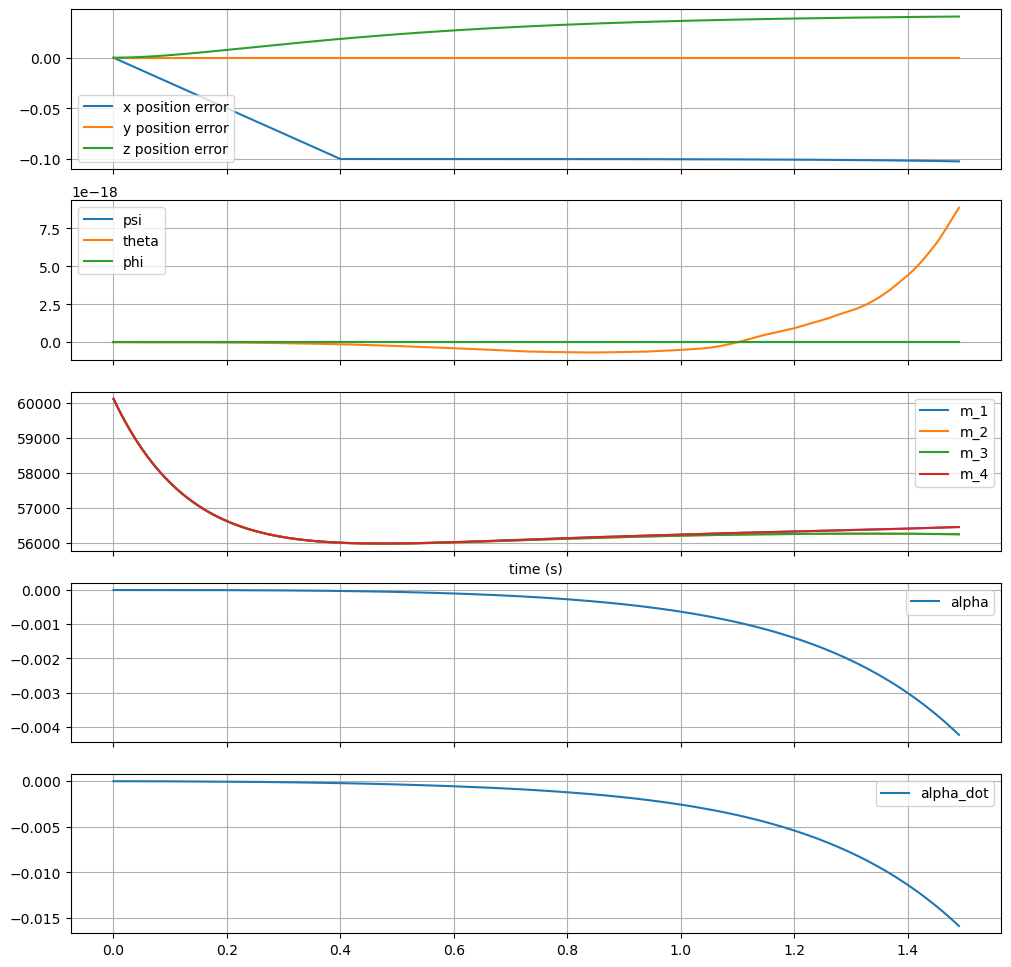

In [136]:
# Plot position error, orientation, pendulum pose and motor power commands

fig, (ax_pos, ax_ori, ax_pow, ax_pen, ax_dot_pen) = plt.subplots(5, 1, figsize=(12, 12), sharex=True)
ax_pos.plot(t, o_x_err, label='x position error')
ax_pos.plot(t, o_y_err, label='y position error')
ax_pos.plot(t, o_z_err, label='z position error')
ax_pos.legend()
ax_pos.grid()
ax_ori.plot(t, psi, label='psi')
ax_ori.plot(t, theta, label='theta')
ax_ori.plot(t, phi, label='phi')
ax_ori.legend()
ax_ori.grid()
ax_pow.plot(t, m_1, label='m_1')
ax_pow.plot(t, m_2, label='m_2')
ax_pow.plot(t, m_3, label='m_3')
ax_pow.plot(t, m_4, label='m_4')
ax_pow.legend()
ax_pow.grid()
ax_pen.plot(t, alpha, label='alpha')
ax_pen.legend()
ax_pen.grid()
ax_dot_pen.plot(t, alpha_dot, label='alpha_dot')
ax_dot_pen.legend()
ax_dot_pen.grid()
ax_pow.set_xlabel('time (s)')

In [137]:
print(o_x)

[ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  5.95824801e-10  2.12999183e-09
  3.95912791e-09  6.25230777e-09  9.27942354e-09  1.29217671e-08
  1.70254057e-08  2.14017633e-08  2.52323008e-08  2.85136933e-08
  3.13459391e-08  3.34429615e-08  3.44858535e-08  3.41232899e-08
  3.25677575e-08  2.97472036e-08  2.51690538e-08  1.76780699e-08
  6.30578365e-09 -8.99657131e-09 -2.85593499e-08 -5.31305946e-08
 -8.35223336e-08 -1.20609931e-07 -1.64735619e-07 -2.17152293e-07
 -2.78714686e-07 -3.50237745e-07 -4.32985137e-07 -5.28315485e-07
 -6.37681398e-07 -7.62032510e-07 -9.03259078e-07 -1.06288298e-06
 -1.24301151e-06 -1.44538141e-06 -1.67171680e-06 -1.92421776e-06
 -2.20461011e-06 -2.51499291e-06 -2.85856921e-06 -3.23784715e-06
 -3.65535076e-06 -4.11351247e-06 -4.61576278e-06 -5.16522060e-06
 -5.76505098e-06 -6.41895237e-06 -7.13080238e-06 -7.90465576e-06
 -8.74414678e-06 -9.65333631e-06 -1.06368460e-05 -1.16995029e-05
 -1.28457422e-05 -1.40804